In [1]:
!pip install matplotlib
!pip install seaborn
!pip install mplcyberpunk
!pip install scikit-learn
!pip install pickle

import pandas as pd
import regex as re
import numpy as np
import logging

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
# ML Modeling
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn.preprocessing import normalize
# Saving and importing trained models
import pickle


df = pd.read_csv('../data/data.csv', delimiter=',', encoding='utf-8')


  Obtaining dependency information for mplcyberpunk from https://files.pythonhosted.org/packages/e5/71/224be8a821e38d71d603077630b36c89038d6295be4e7194219dd649ab60/mplcyberpunk-0.7.1-py3-none-any.whl.metadata


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [2]:
# doing a quick review of the data before developing the model. It looks like we have 4,657 books, and 4 collumns
df.shape

(4657, 4)

In [3]:
df.title

0                       Drowned Wednesday
1                           The Lost Hero
2               The Eyes of the Overworld
3                         Magic's Promise
4                          Taran Wanderer
                      ...                
4652                              Hounded
4653    Charlie and the Chocolate Factory
4654                           Red Rising
4655                            Frostbite
4656                             Radiance
Name: title, Length: 4657, dtype: object

In [4]:
df.columns

Index(['index', 'title', 'genre', 'summary'], dtype='object')

In [5]:
#processing the data for classification

#summaru + title
df['sum_title'] = df['summary'] + ' '+ df['title']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4657 entries, 0 to 4656
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      4657 non-null   int64 
 1   title      4657 non-null   object
 2   genre      4657 non-null   object
 3   summary    4657 non-null   object
 4   sum_title  4657 non-null   object
dtypes: int64(1), object(4)
memory usage: 182.0+ KB


In [6]:
#Now we beging training our model
def _reciprocal_rank(true_genre_labels: list, machine_predicted_genre_labels: list):
  #determining recirprical rank at cutoff
#now wer creaate parameters
        # `true_genre_labels` (List): # List of the actual book genre labels
        # `machine_predicted_genre_labels` (List): # List of book genre labels predicted by the LR algorithm
    
    #The return value will be reciprical rank
    
 # add index to list ONLY if machine predicted label is true 
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_predicted_genre_labels) if r in true_genre_labels]

    recip_rank = 0
    if len(tp_pos_list) > 0:
        # finds fist corectly predicted item
        first_pos_list = tp_pos_list[0]
        
    
        recip_rank = 1 / float(first_pos_list)

    return recip_rank

def compute_mrr_at_k(eval_book_genre_items:list):
    
    ## creating a function that computes Mean reciprical rank

    rr_total = 0
    
    for item in eval_book_genre_items:
        actual_label = item[0]
        pred_label_list = item[1]

        # Finds the reciprocal rank  for this row
        rr_at_k = _reciprocal_rank(actual_label, pred_label_list)

        # Add the row's RR to  scores for the entire data
        rr_total = rr_total + rr_at_k

        # Updates the Mean Reciprocal Rank  score with new row value
        mean_reciprocal_rank_score = rr_total / 1/float(len(eval_book_genre_items))

    return mean_reciprocal_rank_score

def collect_preds(Y_test, Y_preds):
    ##This function will gather all predicted book genres and the true book genres 
    pred_gold_list = [ [ [Y_test[index]], pred ] for index, pred in enumerate(Y_preds) ]
    return pred_gold_list
             
def compute_accuracy(eval_book_genre_items:list):
    
    #this will compute the overall accuracy score our the model 
    correct_book_cat = 0
    
    for book_genre_cat in eval_book_genre_items:
        true_gen = book_genre_cat[0]
        machine_gen = set(book_genre_cat[1])
        
        for book_cat in true_gen:
            if book_cat in machine_gen:
                correct_book_cat += 1
                break
    
    book_cat_prediction_accuracy = correct_book_cat / float(len(eval_book_genre_items))
    return book_cat_prediction_accuracy

In [7]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df, field, training_data, testing_data, type='binary'):
# this function will extract features using different method types: binary, counts, or TF-IDF

    logging.info("Extracting features and creating vocabulary...")
    
    if 'binary' in type:
        
        # Now we are creating a new CountVectorizer()
        cv = CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        train_feature_set = cv.transform(training_data[field].values)
        test_feature_set = cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif 'counts' in type:
        
        cv = CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set = cv.transform(training_data[field].values)
        test_feature_set = cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    elif 'tfidf':    
        
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model, X_test, k, threshold=False):
 # this will use our input to return the book genre with the top estimated probability of being accurate
    if threshold == False:
        probs = model.predict_proba(X_test)
        best_n = np.argsort(probs, axis=1)[:,-k:]
        preds = [[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
        preds = [ item[::-1] for item in preds]
    
        return preds
    else:
        # get probabilities instead of predicted labels
        probs = (model.predict_proba(X_test)[:,1] >= thresh_val)

        # top predictions by probability
        best_n = np.argsort(probs, axis=1)[:,-k:]
        
        # gets category of predictions
        preds = [[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
        
        preds = [ item[::-1] for item in preds]
    
        return preds
   
def train_model(df, field="summary", feature_rep="binary", top_k=3):
 # now we are creating the main control of the function

    y = df['genre']
    x_training_data,x_testing_data = train_test_split(
        df,
        random_state=2000  )

    # getting labels and category values from each split data
    Y_train = x_training_data['genre'].values
    Y_test = x_testing_data['genre'].values
     
    # Extracting features
    X_train,X_test,feature_transformer = extract_features(
        df,
        field,
        x_training_data,
        x_testing_data,
        type=feature_rep
    )

    # start classifier object
    logging.info("Training a Logistic Regression Model. This may take a few minutes. ...")
    scikit_log_reg = LogisticRegression(
        verbose=0, 
        solver='liblinear',
        random_state=0,
        C=5,
        penalty='l2',
        max_iter=1000
    )
    # Create the model
    model = scikit_log_reg.fit(X_train, Y_train)

    # top predictions
    preds = get_top_k_predictions(model, X_test, top_k)
    
    eval_items = collect_preds(Y_test, preds)
    
    # Evaluation on test dat
    logging.info("Starting evaluation...")
    simple_mean_avg_correct_prediction_accuracy = compute_accuracy(eval_items)
    mean_recip_rank_at_k = compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")

    # Return the computed model 
    return model,feature_transformer,simple_mean_avg_correct_prediction_accuracy,mean_recip_rank_at_k,X_train,X_test,Y_test,Y_train,preds,eval_items

BINARY-metric MODEL

In [8]:
'''
  Parameters to configure for our train_model() function
'''

# Use the short description only to train a model
training_field = 'sum_title'
# Specify if this model should use a binary approach to the features (0 or 1) or the actual counts created by CountVectorizer()
feature_rep = 'binary'
# Tell the model function to return the top 3 'best fits' among the distributed probabilities
top_k = 3

# Train that supervised ML logistic regression model!
"""model_td_only,transformer_td_only,accuracy_td_only,mrr_at_k_td_only,X_train,X_test,Y_test,Y_train,preds,eval_items = train_model(
  df, # full corpus
  field=training_field,
  feature_rep=feature_rep,
  top_k=top_k
)"""
binary_model_st,binary_transformer_st,binary_accuracy_st,binary_mrr_at_k_st,binary_X_train,binary_X_test,binary_Y_test,binary_Y_train,binary_preds,binary_eval_items = train_model(
  df, # full corpus
  field=training_field,
  feature_rep=feature_rep,
  top_k=top_k
)

2023-12-11 23:34:50,286 : INFO : Extracting features and creating vocabulary...


2023-12-11 23:34:51,581 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-11 23:34:53,079 : INFO : Starting evaluation...
2023-12-11 23:34:53,080 : INFO : Done training and evaluation.


In [9]:
print(f"Overall Mean Average Model Accuracy = {binary_accuracy_st}\nMean Reciprocal Rank = {binary_mrr_at_k_st}")

Overall Mean Average Model Accuracy = 0.9030042918454936
Mean Reciprocal Rank = 0.7592274678111597


In [10]:
# Predict the classes on the test data
binary_Y_predictions_st = binary_model_st.predict(binary_X_test)
# Predict the classes on the test data, and return the probabilities for each class
binary_Y_probability_a_st = binary_model_st.predict_proba(binary_X_test)

In [11]:
binary_cm_ts = confusion_matrix(
  binary_Y_test, #Sorted List of ground truth (correct/actual) target values
  binary_Y_predictions_st #Sorted List of estimated targets as returned by a classifier
)

In [12]:
# Normalize matrix by columns
binary_cm_st_normed_by_column = normalize(binary_cm_ts, axis=1, norm='l1')
# Compare the original to the normalized
print(
  'Simple Counts of the FANTASY (first) column:\n', binary_cm_ts[0],'\n\n',
  'Normalized Counts of the FANTASY (first) column:\n',binary_cm_st_normed_by_column[0],
)

Simple Counts of the FANTASY (first) column:
 [67  8  3 14  0  0  1  0 26  0] 

 Normalized Counts of the FANTASY (first) column:
 [0.56302521 0.06722689 0.02521008 0.11764706 0.         0.
 0.00840336 0.         0.21848739 0.        ]


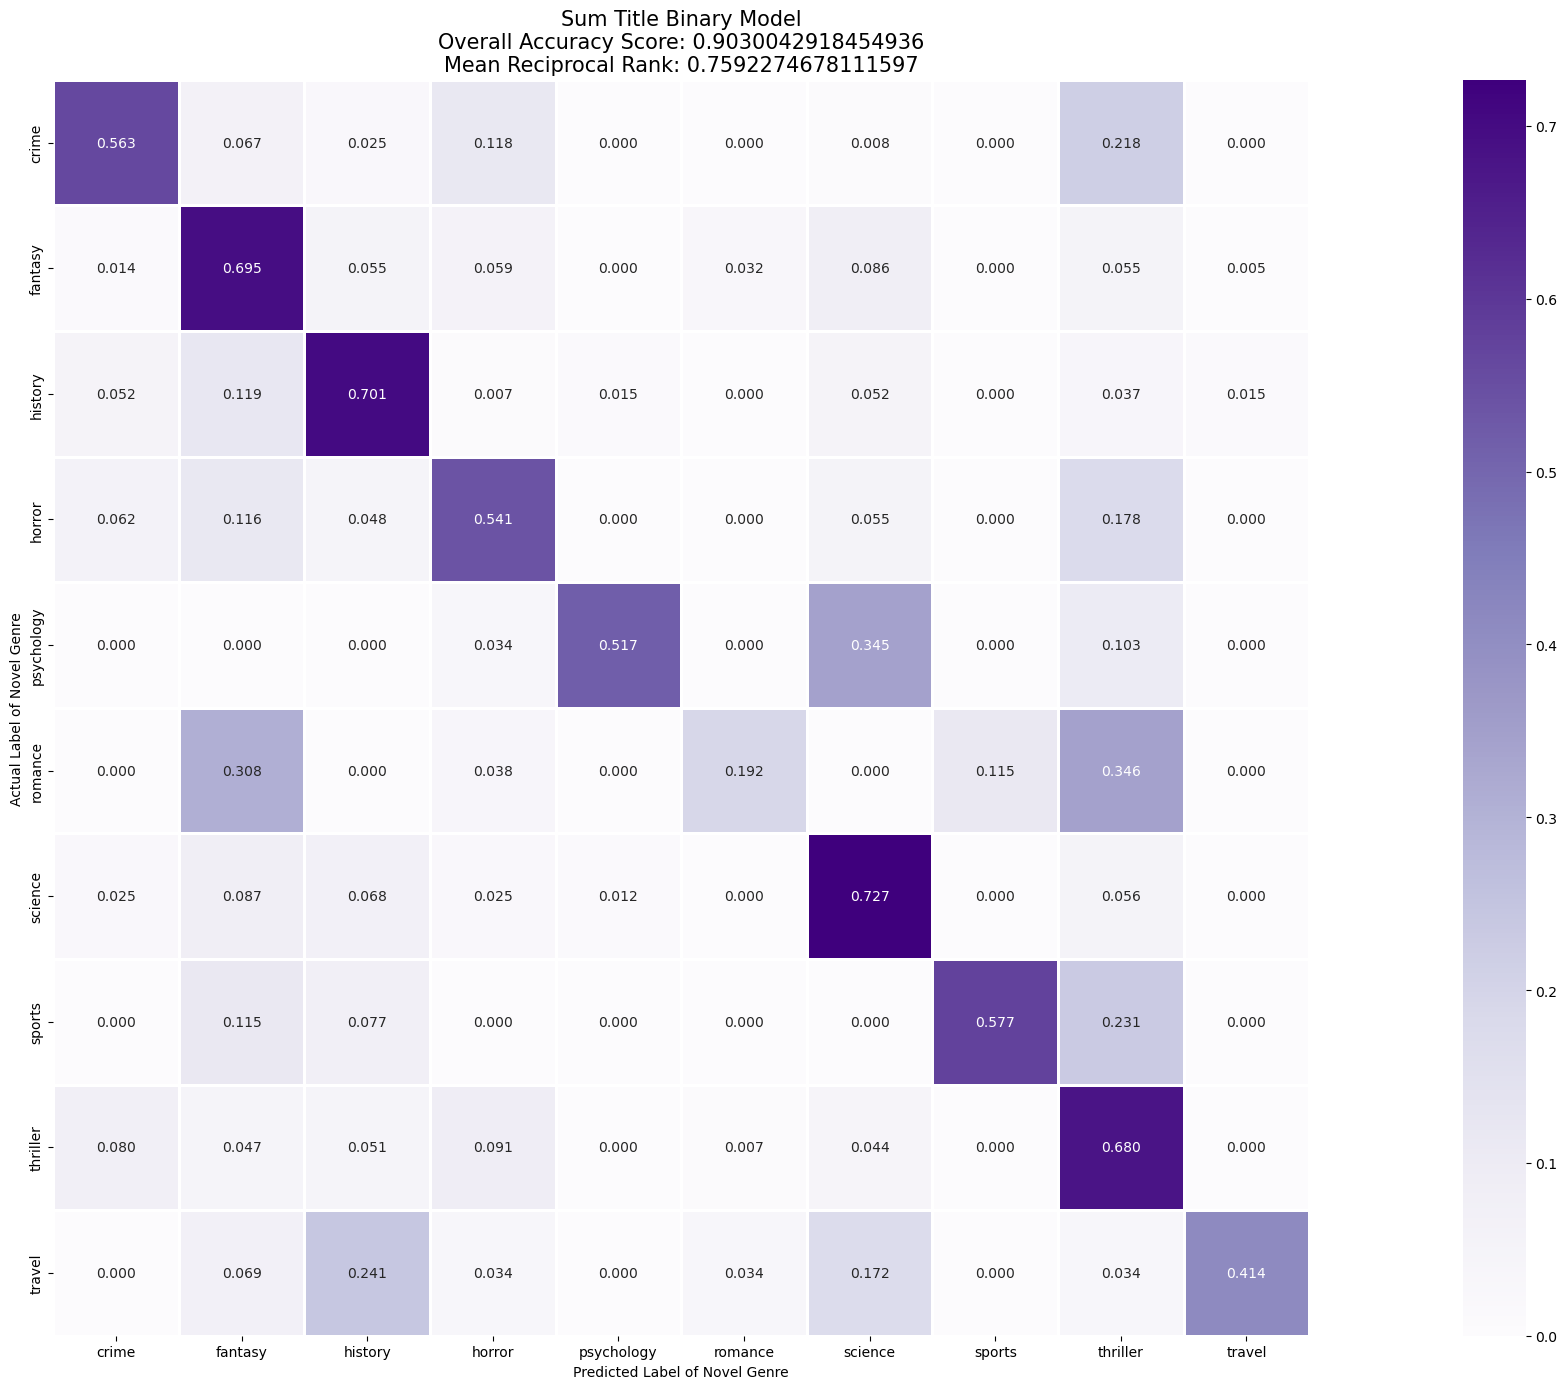

In [13]:
plt.figure(figsize=(31,14))

sns.heatmap(
  binary_cm_st_normed_by_column, #normalized confusion matrix
  annot=True, # add normalized counts of co-occurrences between actual vs. predicted
  fmt=".3f", # round to thousandths decimal place
  linewidths=1, # style choice for row/column lines
  square=True, # make the 
  cmap='Purples',
  xticklabels=binary_model_st.classes_,
  yticklabels=binary_model_st.classes_,
)

# Label the X and Y axes
plt.ylabel('Actual Label of Novel Genre')
plt.xlabel('Predicted Label of Novel Genre')

# Let's plug in our overall accuracy measures into the the title
all_sample_title = f"Sum Title Binary Model\nOverall Accuracy Score: {binary_accuracy_st}\nMean Reciprocal Rank: {binary_mrr_at_k_st}"
plt.title(
  all_sample_title,
  size=15
)

# Ok, output time!
plt.tight_layout()
mplcyberpunk.add_glow_effects()
plt.show()

COUNTS-metric MODEL
Note to Group: Because I'm largely just using the same naming conventions as the previous model, the previous model's variables are being overwritten for the newest model. If we need to reference or use any old models, the naming/variables should be updated.

In [14]:
'''
  Parameters to configure for our train_model() function
'''

# Use the short description only to train a model
training_field = 'sum_title'
# Specify if this model should use a binary approach to the features (0 or 1) or the actual counts created by CountVectorizer()
feature_rep = 'counts'
# Tell the model function to return the top 3 'best fits' among the distributed probabilities
top_k = 3

# Train that supervised ML logistic regression model!
counts_model_st,counts_transformer_st,counts_accuracy_st,counts_mrr_at_k_st,counts_X_train,counts_X_test,counts_Y_test,counts_Y_train,counts_preds,counts_eval_items = train_model(
  df, # full corpus
  field=training_field,
  feature_rep=feature_rep,
  top_k=top_k
)

2023-12-11 23:34:53,611 : INFO : Extracting features and creating vocabulary...
2023-12-11 23:34:54,908 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-11 23:34:57,761 : INFO : Starting evaluation...
2023-12-11 23:34:57,762 : INFO : Done training and evaluation.


In [15]:
print(f"Overall Mean Average Model Accuracy = {counts_accuracy_st}\nMean Reciprocal Rank = {counts_mrr_at_k_st}")

Overall Mean Average Model Accuracy = 0.9072961373390558
Mean Reciprocal Rank = 0.7708154506437775


In [16]:
# Predict the classes on the test data
counts_Y_predictions_st = binary_model_st.predict(counts_X_test)
# Predict the classes on the test data, and return the probabilities for each class
counts_Y_probability_a_st = binary_model_st.predict_proba(counts_X_test)

In [17]:
counts_cm_ts = confusion_matrix(
  counts_Y_test, #Sorted List of ground truth (correct/actual) target values
  counts_Y_predictions_st #Sorted List of estimated targets as returned by a classifier
)

# Normalize matrix by columns
counts_cm_st_normed_by_column = normalize(counts_cm_ts, axis=1, norm='l1')
# Compare the original to the normalized
print(
  'Simple Counts of the FANTASY (first) column:\n', counts_cm_ts[0],'\n\n',
  'Normalized Counts of the FANTASY (first) column:\n',counts_cm_st_normed_by_column[0],
)

Simple Counts of the FANTASY (first) column:
 [81  3  4  8  0  0  0  0 23  0] 

 Normalized Counts of the FANTASY (first) column:
 [0.68067227 0.02521008 0.03361345 0.06722689 0.         0.
 0.         0.         0.19327731 0.        ]


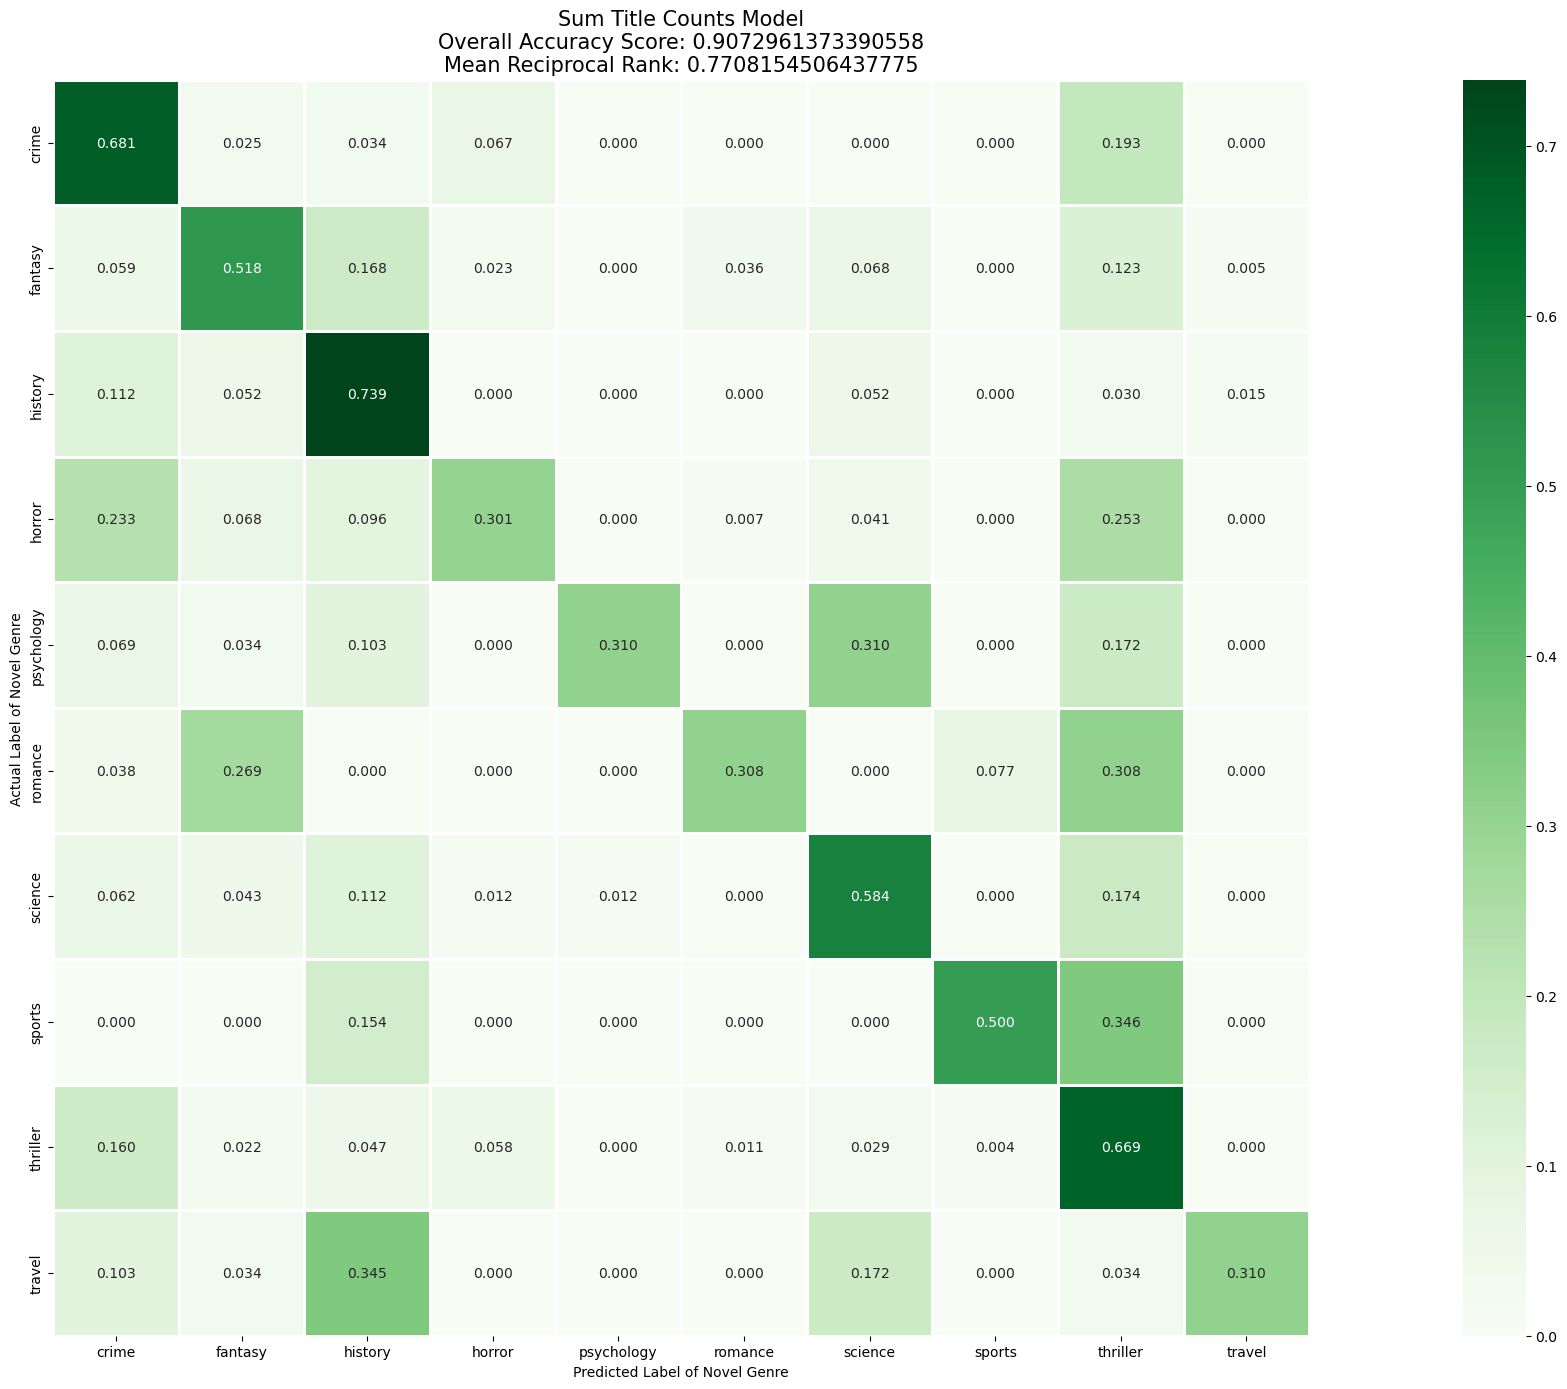

In [18]:
plt.figure(figsize=(31,14))

sns.heatmap(
  counts_cm_st_normed_by_column, #normalized confusion matrix
  annot=True, # add normalized counts of co-occurrences between actual vs. predicted
  fmt=".3f", # round to thousandths decimal place
  linewidths=1, # style choice for row/column lines
  square=True, # make the 
  cmap='Greens',
  xticklabels=counts_model_st.classes_,
  yticklabels=counts_model_st.classes_,
)

# Label the X and Y axes
plt.ylabel('Actual Label of Novel Genre')
plt.xlabel('Predicted Label of Novel Genre')

# Let's plug in our overall accuracy measures into the the title
all_sample_title = f"Sum Title Counts Model\nOverall Accuracy Score: {counts_accuracy_st}\nMean Reciprocal Rank: {counts_mrr_at_k_st}"
plt.title(
  all_sample_title,
  size=15
)

# Ok, output time!
plt.tight_layout()
mplcyberpunk.add_glow_effects()
plt.show()

TDIDF-metric Model

In [19]:
'''
  Parameters to configure for our train_model() function
'''

# Use the short description only to train a model
training_field = 'sum_title'
# Specify if this model should use a binary approach to the features (0 or 1) or the actual counts created by CountVectorizer()
feature_rep = 'tfidf'
# Tell the model function to return the top 3 'best fits' among the distributed probabilities
top_k = 3

# Train that supervised ML logistic regression model!
tfidf_model_st,tfidf_transformer_st,tfidf_accuracy_st,tfidf_mrr_at_k_st,tfidf_X_train,tfidf_X_test,tfidf_Y_test,tfidf_Y_train,tfidf_preds,tfidf_eval_items = train_model(
  df, # full corpus
  field=training_field,
  feature_rep=feature_rep,
  top_k=top_k
)

2023-12-11 23:34:58,129 : INFO : Extracting features and creating vocabulary...
2023-12-11 23:34:59,507 : INFO : Training a Logistic Regression Model. This may take a few minutes. ...
2023-12-11 23:35:00,136 : INFO : Starting evaluation...
2023-12-11 23:35:00,138 : INFO : Done training and evaluation.


In [20]:
print(f"Overall Mean Average Model Accuracy = {tfidf_accuracy_st}\nMean Reciprocal Rank = {tfidf_mrr_at_k_st}")

Overall Mean Average Model Accuracy = 0.903862660944206
Mean Reciprocal Rank = 0.7799713876967105


In [21]:
# Predict the classes on the test data
tfidf_Y_predictions_st = tfidf_model_st.predict(tfidf_X_test)
# Predict the classes on the test data, and return the probabilities for each class
tfidf_Y_probability_a_st = tfidf_model_st.predict_proba(tfidf_X_test)

In [22]:
tfidf_cm_ts = confusion_matrix(
  tfidf_Y_test, #Sorted List of ground truth (correct/actual) target values
  tfidf_Y_predictions_st #Sorted List of estimated targets as returned by a classifier
)

# Normalize matrix by columns
tfidf_cm_st_normed_by_column = normalize(tfidf_cm_ts, axis=1, norm='l1')
# Compare the original to the normalized
print(
  'Simple Counts of the FANTASY (first) column:\n', tfidf_cm_ts[0],'\n\n',
  'Normalized Counts of the FANTASY (first) column:\n',tfidf_cm_st_normed_by_column[0],
)

Simple Counts of the FANTASY (first) column:
 [71  1  3  7  0  0  0  0 37  0] 

 Normalized Counts of the FANTASY (first) column:
 [0.59663866 0.00840336 0.02521008 0.05882353 0.         0.
 0.         0.         0.31092437 0.        ]


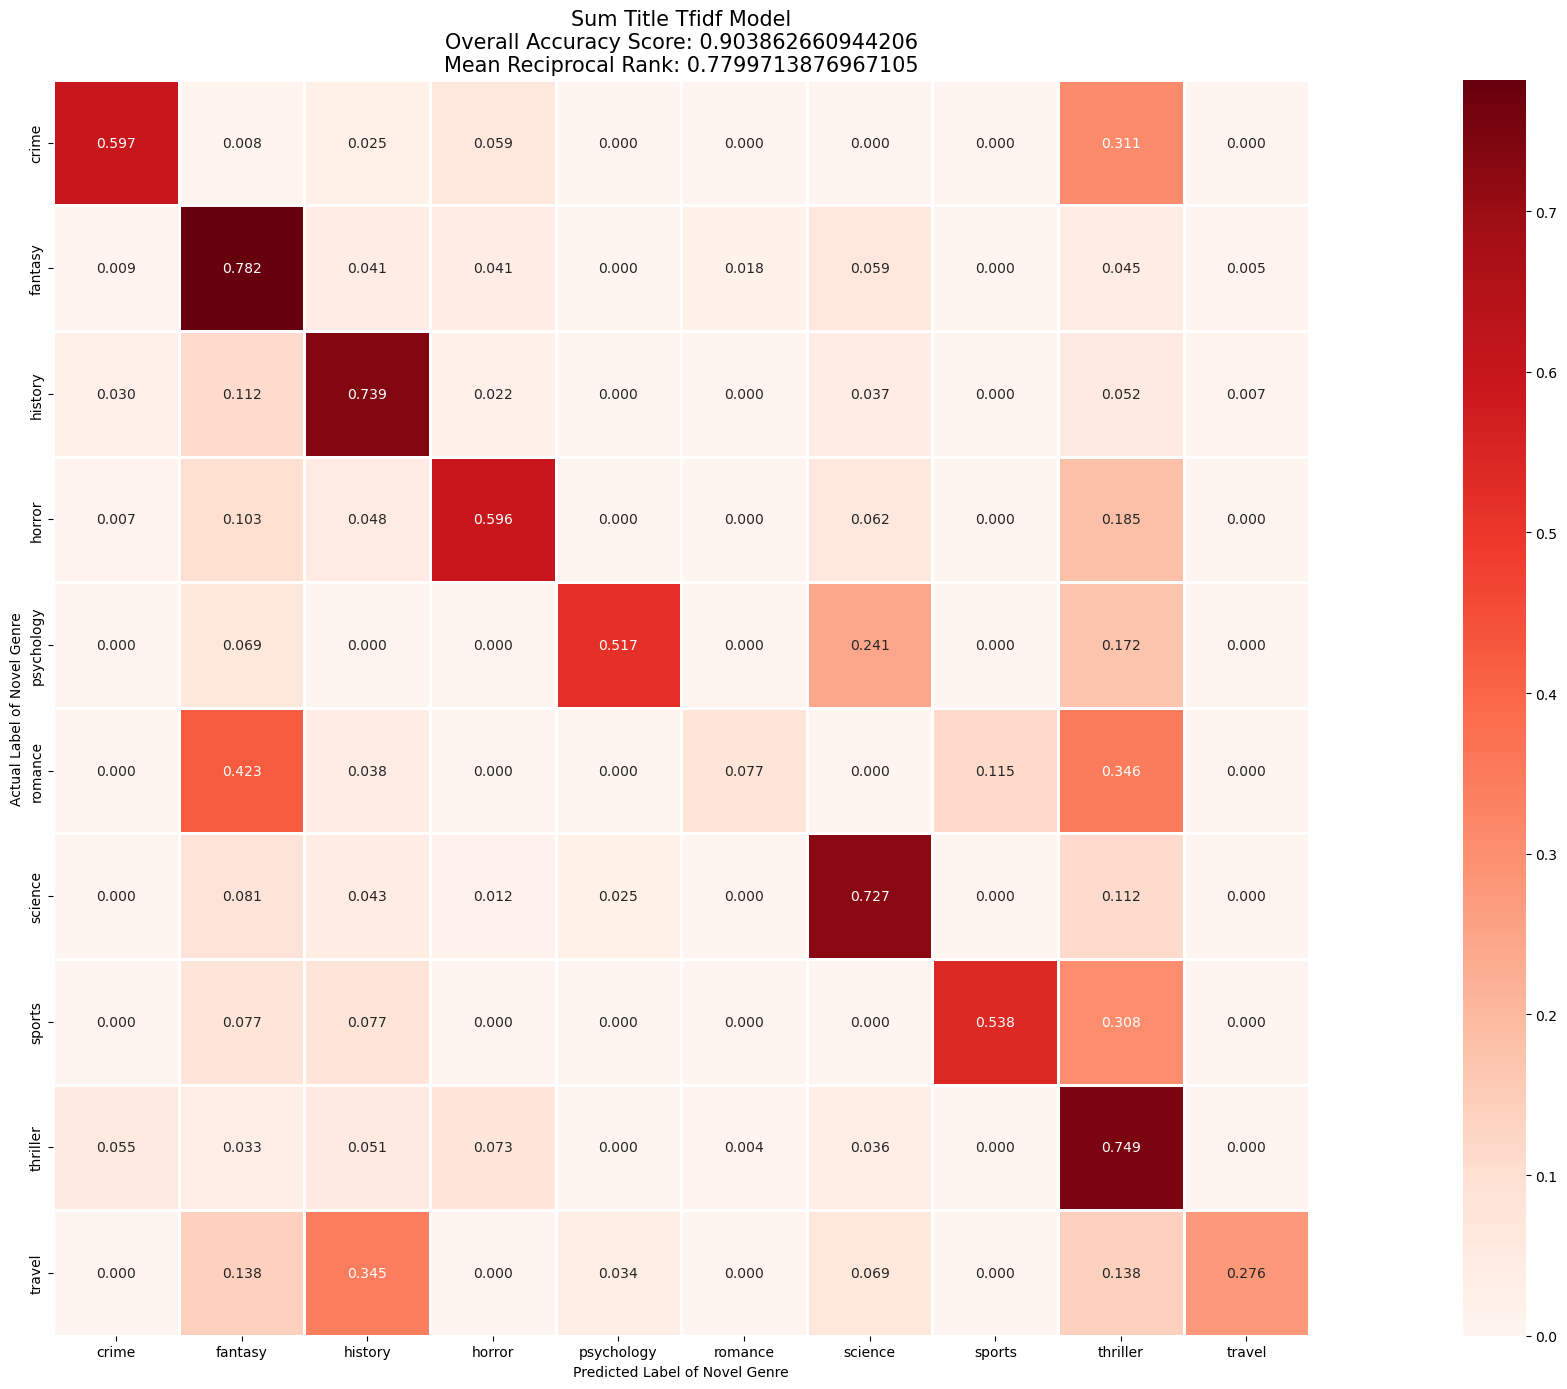

In [23]:
plt.figure(figsize=(31,14))

sns.heatmap(
  tfidf_cm_st_normed_by_column, #normalized confusion matrix
  annot=True, # add normalized counts of co-occurrences between actual vs. predicted
  fmt=".3f", # round to thousandths decimal place
  linewidths=1, # style choice for row/column lines
  square=True, # make the 
  cmap='Reds',
  xticklabels=tfidf_model_st.classes_,
  yticklabels=tfidf_model_st.classes_,
)

# Label the X and Y axes
plt.ylabel('Actual Label of Novel Genre')
plt.xlabel('Predicted Label of Novel Genre')

# Let's plug in our overall accuracy measures into the the title
all_sample_title = f"Sum Title Tfidf Model\nOverall Accuracy Score: {tfidf_accuracy_st}\nMean Reciprocal Rank: {tfidf_mrr_at_k_st}"
plt.title(
  all_sample_title,
  size=15
)

# Ok, output time!
plt.tight_layout()
mplcyberpunk.add_glow_effects()
plt.show()